# Model Assessment

In [1]:
from tqdm.notebook import tqdm
import pickle, gzip
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

import nibabel as nib
from nilearn import maskers
from nilearn import plotting, datasets, image
from nilearn.plotting.displays import MosaicSlicer
from nilearn.image import resample_img
from nilearn.plotting import plot_stat_map, view_img


from neurovlm.data import data_dir
from neurovlm.data import get_data_dir
from neurovlm.models import Specter
from neurovlm.retrieval_resources import _load_autoencoder

from neurovlm.brain_input import search_papers_from_brain, search_wiki_from_brain, resample_array_nifti, _load_mask_bundle, search_cogatlas_from_brain

In [2]:
with gzip.open(get_data_dir() / f"networks_arrays.pkl.gz", "rb") as f:
    networks = pickle.load(f)

proj_head_mse_adhoc = torch.load(get_data_dir() / f"proj_head_image_infonce.pt", weights_only=False).cpu()
proj_head_img = torch.load(get_data_dir() / f"proj_head_image_infonce.pt", weights_only=False).cpu()
proj_head_text = torch.load(get_data_dir() / f"proj_head_text_infonce.pt", weights_only=False).cpu()
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query")
autoencoder = torch.load(get_data_dir() / "autoencoder_sparse.pt", weights_only=False).cpu()
# decoder = autoencoder.decoder.to("cpu")
mask_arrays = np.load(f"{get_data_dir()}/mask.npz", allow_pickle=True)
mask_img = nib.Nifti1Image(mask_arrays["mask"].astype(float),  mask_arrays["affine"])
masker = maskers.NiftiMasker(mask_img=mask_img, dtype=np.float32).fit()

There are adapters available but none are activated for the forward pass.


## Network vs. articles

In [3]:
networks = {k: v for _k in networks.keys() for k, v in networks[_k].items()}

In [4]:
mask_arrays = np.load(f"{get_data_dir()}/mask.npz", allow_pickle=True)
mask_img = nib.Nifti1Image(mask_arrays["mask"].astype(float),  mask_arrays["affine"])
masker = maskers.NiftiMasker(mask_img=mask_img, dtype=np.float32).fit()
networks_resampled = {}

for k in tqdm(networks.keys(), total=len(networks)):
    img = nib.Nifti1Image(networks[k]["array"], affine=networks[k]["affine"])

    if len(np.unique(networks[k]["array"])) == 2:
        # binary data
        img_resampled = resample_img(img, mask_arrays["affine"], interpolation="nearest")
    else:
        img_resampled = resample_img(img, mask_arrays["affine"])
        img_resampled_arr = img_resampled.get_fdata()
        img_resampled_arr[img_resampled_arr < 0] = 0.
        thresh = np.percentile(img_resampled_arr.flatten(), 95)
        img_resampled_arr[img_resampled_arr < thresh] = 0.
        img_resampled_arr[img_resampled_arr >= thresh] = 1.
        img_resampled = nib.Nifti1Image(img_resampled_arr, affine=mask_arrays["affine"])

    networks_resampled[k] = img_resampled

  0%|          | 0/152 [00:00<?, ?it/s]

In [5]:
networks_embed = {}

for k, v in tqdm(networks_resampled.items(), total=len(networks_resampled)):
    networks_embed[k] = autoencoder.encoder(torch.from_numpy(masker.transform(v)))

  0%|          | 0/152 [00:00<?, ?it/s]

In [6]:
brain_network_abbrev = {
    # Primary abbreviations with clear expansions
    'VIS-P': 'Visual - Primary/Peripheral',
    'DN-B': 'Default Network - B',
    'SMOT-B': 'Sensorimotor - B',
    'AUD': 'Auditory',
    'dATN-B': 'Dorsal Attention Network - B',
    'SMOT-A': 'Sensorimotor - A',
    'LANG': 'Language',
    'FPN-B': 'Frontoparietal Network - B',
    'FPN-A': 'Frontoparietal Network - A',
    'dATN-A': 'Dorsal Attention Network - A',
    'VIS-C': 'Visual - Central/Core',
    'SAL/PMN': 'Salience/Posterior Multimodal Network',
    'DN-A': 'Default Network - A',
    'Visual1': 'Visual Network 1',
    'Visual2': 'Visual Network 2',
    'Visual3': 'Visual Network 3',
    'Somatomotor': 'Somatomotor',
    'CingOperc': 'Cingulo-Opercular',
    'DorsAttn': 'Dorsal Attention',
    'Language': 'Language',
    'FrontPar': 'Frontoparietal',
    'Auditory': 'Auditory',
    'Default': 'Default Mode Network',
    'PostMulti': 'Posterior Multimodal',
    'VentMulti': 'Ventral Multimodal',
    'OrbitAffective': 'Orbitofrontal Affective',

    # Functional categories
    'Emo/Interoception1': 'Emotion/Interoception Network 1',
    'Emo/Interoception2': 'Emotion/Interoception Network 2',
    'Emo/Interoception3': 'Emotion/Interoception Network 3',
    'Emo/Interoception4': 'Emotion/Interoception Network 4',
    'Mot/Visspatial1': 'Motor/Visuospatial Network 1',
    'Mot/Visspatial2': 'Motor/Visuospatial Network 2',
    'Mot/Visspatial3': 'Motor/Visuospatial Network 3',
    'Mot/Visspatial4': 'Motor/Visuospatial Network 4',
    'DivergentCog1': 'Divergent Cognitive Network 1',
    'DivergentCog3': 'Divergent Cognitive Network 3',
    'DivergentCog4': 'Divergent Cognitive Network 4',
    'DivergentCog5': 'Divergent Cognitive Network 5',
    'DivergentCog6': 'Divergent Cognitive Network 6',

    # Descriptive names
    'medial frontal': 'Medial Frontal',
    'frontoparietal': 'Frontoparietal',
    'default mode': 'Default Mode Network',
    'motor cortex': 'Motor Cortex',
    'visual A': 'Visual Network A',
    'visual B': 'Visual Network B',
    'visual association': 'Visual Association',
    'subcortical cerebellum': 'Subcortical Cerebellum',

    # More specific networks
    'AntSal': 'Anterior Salience',
    'DorsalDMN': 'Dorsal Default Mode Network',
    'HighVisual': 'Higher-Order Visual',
    'LECN': 'Left Executive Control Network',
    'PostSal': 'Posterior Salience',
    'Precuneus': 'Precuneus Network',
    'PrimVisual': 'Primary Visual',
    'RECN': 'Right Executive Control Network',
    'Sensorimotor': 'Sensorimotor',
    'VentralDMN': 'Ventral Default Mode Network',
    'Visuospatial': 'Visuospatial',
    'LatVis': 'Lateral Visual',
    'MedVis': 'Medial Visual',
    'Premotor': 'Premotor',
    'Salience': 'Salience',

    # Effector-specific
    'HandSM': 'Hand Sensorimotor',
    'FaceSM': 'Face Sensorimotor',
    'FootSM': 'Foot Sensorimotor',
    'Effector-hand': 'Hand Effector',
    'Effector-mouth': 'Mouth Effector',
    'Effector-foot': 'Foot Effector',

    # Memory systems
    'AntMTL': 'Anterior Medial Temporal Lobe',
    'PostMTL': 'Posterior Medial Temporal Lobe',
    'ParMemory': 'Parietal Memory',
    'Context': 'Context Network',

    # Other networks
    'Visual': 'Visual',
    'VentAttn': 'Ventral Attention',
    'DorsalSM': 'Dorsal Sensorimotor',
    'VentralSM': 'Ventral Sensorimotor',
    'MedPar': 'Medial Parietal',
    'ParOcc': 'Parietal-Occipital',
    'Cingulo-Opercular': 'Cingulo-Opercular',
    'SM': 'Sensorimotor',
    'LateralSM': 'Lateral Sensorimotor',

    # Task-related
    'ResponseOneHanded(1RESP)': 'Response One-Handed',
    'ResponseTwoHanded(2RESP)': 'Response Two-Handed',
    'AuditoryAttentionResponse(AAR)': 'Auditory Attention Response',
    'AuditoryPrimarySensory(AUD)': 'Auditory Primary Sensory',
    'DMNNovel(DMNA)': 'Default Mode Network - Novel',
    'DMNTraditional(DMNB)': 'Default Mode Network - Traditional',
    'FocusOnVisualFeatures(FoVF)': 'Focus on Visual Features',
    'Initiation(INIT)': 'Initiation',
    'Language(LN)': 'Language',
    'MultipleDemand(MDN)': 'Multiple Demand Network',
    'Re-evaluation(RE-EV)': 'Re-evaluation',

    # Yeo-style subdivisions
    'DefaultA': 'Default Mode Network A',
    'DefaultB': 'Default Mode Network B',
    'DefaultC': 'Default Mode Network C',
    'ControlA': 'Control Network A',
    'ControlB': 'Control Network B',
    'ControlC': 'Control Network C',
    'Control': 'Control Network',
    'SalVenAttnA': 'Salience/Ventral Attention A',
    'SalVenAttnB': 'Salience/Ventral Attention B',
    'SalVentAttnA': 'Salience/Ventral Attention A',
    'SalVentAttnB': 'Salience/Ventral Attention B',
    'Sal/VenAttnA': 'Salience/Ventral Attention A',
    'Sal/VenAttnB': 'Salience/Ventral Attention B',
    'Sal/VenAttn': 'Salience/Ventral Attention',
    'DorsAttnA': 'Dorsal Attention A',
    'DorsAttnB': 'Dorsal Attention B',
    'Aud': 'Auditory',
    'SomMotA': 'Somatomotor A',
    'SomMotB': 'Somatomotor B',
    'SomatomotorA': 'Somatomotor A',
    'SomatomotorB': 'Somatomotor B',
    'VisualA': 'Visual A',
    'VisualB': 'Visual B',
    'VisualC': 'Visual C',
    'VisPeri': 'Visual Peripheral',
    'VisCent': 'Visual Central',
    'TempPar': 'Temporal-Parietal',
    'LimbicA': 'Limbic A',
    'LimbicB': 'Limbic B',
    'Limbic': 'Limbic',
}

In [7]:
abstract, titles, similarity_score = search_papers_from_brain(networks_embed["Visual1"], show_titles=True)

Top matches:
1. Common and distinct brain activation to viewing dynamic sequences of face and hand movements.
2. The neural representation of human versus nonhuman bipeds and quadrupeds
3. The Mona Lisa effect: Neural correlates of centered and off-centered gaze.
4. What Makes Eye Contact Special? Neural Substrates of On-Line Mutual Eye-Gaze: A Hyperscanning fMRI Study
5. Comparative Brain Imaging Reveals Analogous and Divergent Patterns of Species and Face Sensitivity in Humans and Dogs


In [8]:
similarity_score

array([0.49415398, 0.47872347, 0.47638857, 0.47117653, 0.46807933],
      dtype=float32)

In [9]:
wiki_title, wiki_summary, wiki_similarity_score = search_wiki_from_brain(networks_embed["Visual1"], show_titles=True)

Top matches:
1. Visual temporal attention
2. Interocular transfer


In [10]:
wiki_similarity_score

array([0.42092273, 0.394619  ], dtype=float32)

In [11]:
cogatlas_title, cogatlas_description, cogatlas_similarity_score = search_cogatlas_from_brain(networks_embed["Visual1"], show_titles=True)

Top matches:
1. embodied cognition
2. visual search
3. temporal cognition
4. object perception
5. blindsight


In [12]:
cogatlas_similarity_score

array([0.29497838, 0.29138774, 0.29109022, 0.2898947 , 0.2837941 ],
      dtype=float32)

# Ploting the Brain map

Network: Visual1
Data range: 0.0 to 1.0
Unique values: [0. 1.]
Non-zero voxels: 5819


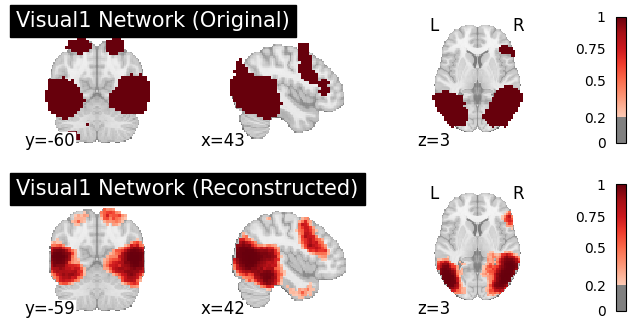

In [13]:
# Select the network to visualize
network_name = "Visual1"
network_img = networks_resampled[network_name]

# Check the data range to understand what we're plotting
network_data = network_img.get_fdata()
print(f"Network: {network_name}")
print(f"Data range: {network_data.min()} to {network_data.max()}")
print(f"Unique values: {np.unique(network_data)}")
print(f"Non-zero voxels: {np.sum(network_data > 0)}")

# Predicted image
autoencoder = _load_autoencoder()
mask_arrays, _, masker = _load_mask_bundle(data_dir=data_dir)

# Transform network image to 1D vector and add batch dimension
network_transformed = torch.from_numpy(masker.transform(network_img)).unsqueeze(0)

# Pass through autoencoder and remove batch dimension
reconstruction = autoencoder(network_transformed)
# Handle both tuple and tensor returns
if isinstance(reconstruction, tuple):
    reconstruction = reconstruction[0]
img_pred = masker.inverse_transform(
    torch.sigmoid(reconstruction).squeeze(0).detach().numpy()
)

# Create brain map visualization
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))

# Plot the original network brain map
plot_stat_map(network_img,
              cmap="Reds",
              vmin=0, vmax=1,
              threshold=0.2,
              draw_cross=False,
              axes=axes[0],
              title=f'{network_name} Network (Original)');

# Plot the predicted/reconstructed network
plot_stat_map(img_pred,
              cmap="Reds",
              vmin=0, vmax=1,
              threshold=0.2,
              draw_cross=False,
              axes=axes[1],
              title=f'{network_name} Network (Reconstructed)');